## Imports 


In [2]:
# data 
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# modeling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# parameter tuning
from sklearn.model_selection import GridSearchCV

# performance
from helper_functions import *
from sklearn.metrics import *

# save model 
import pickle


## Loading Data From MySQL

The etl that uses kaggle api is available in the Loan_Data_ETL_Approval_Prediction repo. 

In [ ]:
try:
    mydb = mysql.connector.connect(
        host = "YOURHOST",
        user = "YOURROOT",
        password = "YOURPASSWORD",
        database = "loan_db", 
    )
    query = "Select * From loan_approval;"
    df = pd.read_sql(query,mydb)
    mydb.close() 

except:
    print('error')

## Dealing with n/a values 
    
Replaced missing values with the mean for numeric features and most common for categorical 

In [3]:
# drop not needed columns 
df = df.drop(columns=['Loan_ID'])

# dealing with na values 
print('Number of missing values by Columns')
print(df.isnull().sum())

df['Gender'].fillna(df['Gender'].value_counts().idxmax(), inplace=True)
df['Married'].fillna(df['Married'].value_counts().idxmax(), inplace=True)
df['Dependents'].fillna(df['Dependents'].value_counts().idxmax(), inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].value_counts().idxmax(), inplace=True)
df["LoanAmount"].fillna(df["LoanAmount"].mean(skipna=True), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].value_counts().idxmax(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].value_counts().idxmax(), inplace=True)

df.isnull().sum()

Number of missing values by Columns
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Feature Engineering

Total income rather than having two seperate incomes 

<AxesSubplot:xlabel='Total_Income', ylabel='Count'>

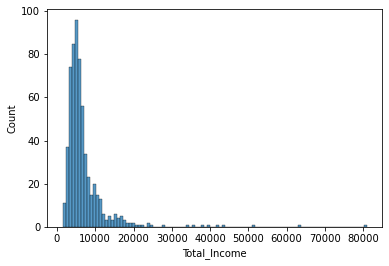

In [4]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
sns.histplot(df['Total_Income'])

<AxesSubplot:xlabel='Total_Income_log', ylabel='Count'>

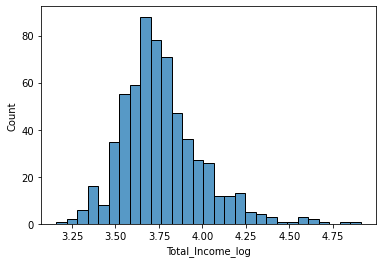

In [5]:
df['Total_Income_log'] = np.log10(df['ApplicantIncome'] + df['CoapplicantIncome'])
sns.histplot(df['Total_Income_log'])

Equated Monthly Installment (EMI) rather than loan amount and term. 

Reference for Equated Monthly Installment (EMI)  
https://www.investopedia.com/terms/e/equated_monthly_installment.asp

<AxesSubplot:xlabel='EMI', ylabel='Count'>

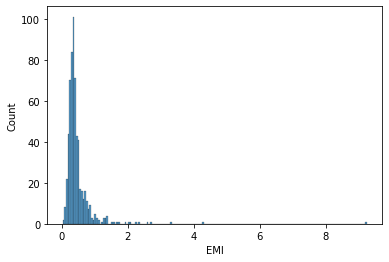

In [6]:
# reference for Equated Monthly Installment (EMI)  
# https://www.investopedia.com/terms/e/equated_monthly_installment.asp

df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

sns.histplot(df['EMI'])

Drop features that were used to make new features to prevent multicollinearity 

In [7]:
df.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount', 'Loan_Amount_Term']
        , axis = 1
        , inplace = True)

## Encoding Features 


In [8]:
encoding_categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                       'Property_Area','Loan_Status']

In [9]:
ohe_encoder = OneHotEncoder()
ohe_encoded_data = ohe_encoder.fit_transform(df[encoding_categorical_features])
ohe_encoded_df = pd.DataFrame(ohe_encoded_data.toarray()
                              , columns = ohe_encoder.get_feature_names_out(encoding_categorical_features))

df_ohe_encoded = pd.concat([df, ohe_encoded_df], axis=1)
df_ohe_encoded.drop(encoding_categorical_features, axis =1 ,inplace = True)
df_ohe_encoded.head()

,Credit_History,Total_Income,Total_Income_log,EMI,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
0,1.0,5849.0,3.767082,0.406700,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,6091.0,3.784689,0.355556,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,3000.0,3.477121,0.183333,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,4941.0,3.693815,0.333333,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,6000.0,3.778151,0.391667,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


## Spliting Our Data 

Starting with a 70 30 training and testing set for model building

In [10]:
x = df_ohe_encoded.drop(columns=['Loan_Status_Y','Loan_Status_N','Total_Income'])
y = df_ohe_encoded['Loan_Status_Y']


x_train,x_test,y_train,y_test = train_test_split(x, y
                                            , train_size=0.7, random_state = 42)

## Model Buidling, Machine Learning Classification

Logistic Regression, Random Forest, and Gradient Boosting Classifier will be used. Performance will be mesaured using F1, Accuary, Percesion, and ROC-AUC. Followed by parameter tuning. 

In [11]:
# log reg fit and predict

log = LogisticRegression()

log.fit(x_train, y_train)

y_pred_log = log.predict(x_test)

y_log_proba = log.predict_proba(x_test)

f1_score: 0.8551
precision_score: 0.7564
recall_score: 0.9833
accuracy_score: 0.7838


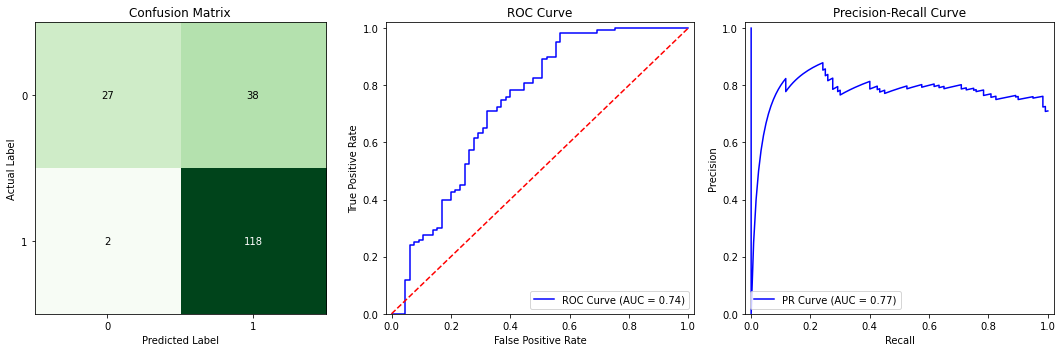

f1_scores for each fold [0.8707, 0.8688, 0.8852] ...... average 0.8749
precision_scores for each fold [0.7841, 0.7765, 0.8182] ...... average 0.7929
recall_scores for each fold [0.9787, 0.9858, 0.9643] ...... average 0.9763
accuracy_scores for each fold [0.8, 0.7951, 0.8284] ...... average 0.8078


In [17]:
# log reg evaluation
classification_metrics(y_test, y_pred_log)
performance_eval(y_test, y_pred_log, y_log_proba[:, 1])
stratified_cv_(LogisticRegression(), x, y, n_splits=3)

In [18]:
# rfc fit and predict

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(x_train,y_train)

y_pred_rfc = rfc.predict(x_test)

y_rfc_proba = rfc.predict_proba(x_test)

f1_score: 0.8441
precision_score: 0.7762
recall_score: 0.9250
accuracy_score: 0.7784


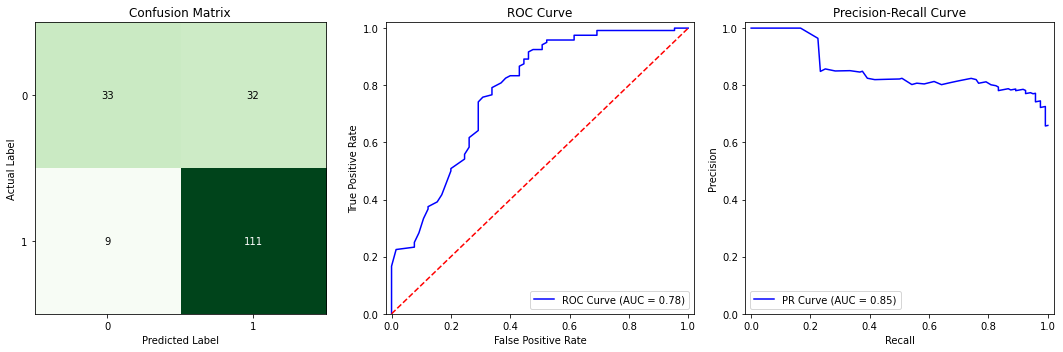

f1_scores for each fold [0.8267, 0.8571, 0.8658] ...... average 0.8499
precision_scores for each fold [0.7799, 0.7904, 0.8165] ...... average 0.7956
recall_scores for each fold [0.8794, 0.9362, 0.9214] ...... average 0.9123
accuracy_scores for each fold [0.7463, 0.7854, 0.8039] ...... average 0.7785


In [19]:
# rfc evaluation

classification_metrics(y_test, y_pred_rfc)
performance_eval(y_test,y_pred_rfc,y_rfc_proba[:, 1])
stratified_cv_(RandomForestClassifier(random_state = 42), x, y, n_splits=3)

In [20]:
# gbc fit and predict

gbc = GradientBoostingClassifier(random_state = 42, learning_rate = 0.3, max_depth = 6)

gbc.fit(x_train,y_train)

y_pred_gbc = gbc.predict(x_test)

y_gbc_proba = gbc.predict_proba(x_test)

f1_score: 0.8333
precision_score: 0.7639
recall_score: 0.9167
accuracy_score: 0.7622


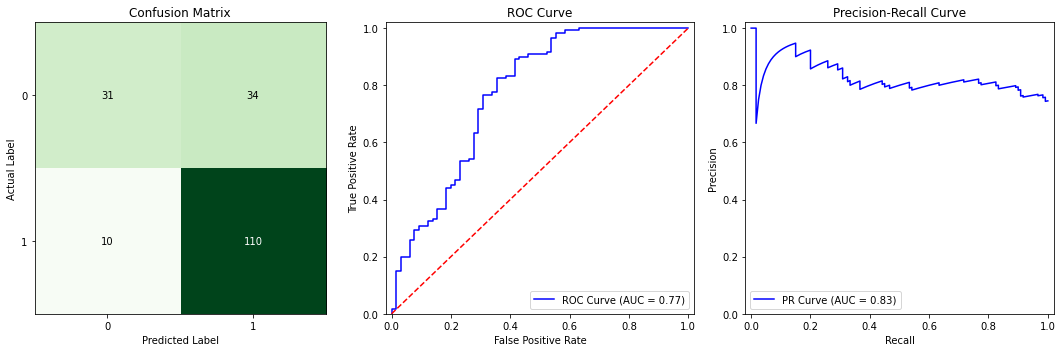

f1_scores for each fold [0.8138, 0.8138, 0.8198] ...... average 0.8158
precision_scores for each fold [0.7919, 0.7919, 0.8112] ...... average 0.7983
recall_scores for each fold [0.8369, 0.8369, 0.8286] ...... average 0.8341
accuracy_scores for each fold [0.7366, 0.7366, 0.75] ...... average 0.7411


In [21]:
# gbc evaluation

classification_metrics(y_test, y_pred_gbc)
performance_eval(y_test,y_pred_gbc,y_gbc_proba[:, 1])
stratified_cv_(GradientBoostingClassifier(random_state = 42
                        , learning_rate = 0.3, max_depth = 6), x, y, n_splits=3)

## Hyperparameter Tunning 

In [22]:
def paramter_tunning(xtrain,ytrain,type_model,parameters,cv_num,scoring_metric):
    
    model = type_model
    
    gs = GridSearchCV(estimator = type_model
                    ,param_grid = parameters
                    ,scoring = scoring_metric
                    ,cv = cv_num
                     ) 
    gs.fit(xtrain,ytrain)
    
    return gs.best_params_ 
    

In [23]:
#rfc

param_grid = {
    'n_estimators': [15, 25, 50, 75, 85, 95 ,100, 150],
    'min_samples_split': [10,15, 20, 50],
    'max_depth': [3, 4, 5, 6, 7],     
}

best_rfc_para = paramter_tunning(x_train,y_train
                                 ,RandomForestClassifier(random_state = 42)
                                 ,param_grid
                                 ,3
                                 ,'average_precision')
print(best_rfc_para)

{'max_depth': 4, 'min_samples_split': 50, 'n_estimators': 15}


f1_score: 0.8551
precision_score: 0.7564
recall_score: 0.9833
accuracy_score: 0.7838


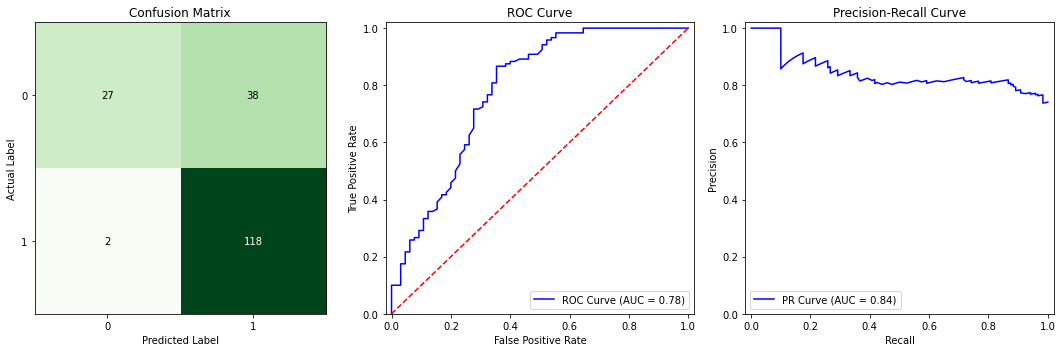

f1_scores for each fold [0.8698, 0.8688, 0.8903] ...... average 0.8763
precision_scores for each fold [0.7874, 0.7765, 0.8118] ...... average 0.7919
recall_scores for each fold [0.9716, 0.9858, 0.9857] ...... average 0.981
accuracy_scores for each fold [0.8, 0.7951, 0.8333] ...... average 0.8095


In [24]:
rfc_tune = RandomForestClassifier(**best_rfc_para,random_state = 42)

rfc_tune.fit(x_train,y_train)

y_pred_rfc = rfc_tune.predict(x_test)

y_rfc_proba = rfc_tune.predict_proba(x_test)

classification_metrics(y_test, y_pred_rfc)
performance_eval(y_test,y_pred_rfc,y_rfc_proba[:, 1])
stratified_cv_(RandomForestClassifier(**best_rfc_para,random_state = 42), x, y, n_splits=3)

In [25]:
# gbc 

parameters_gbc = {
    "n_estimators":[25, 50, 75, 85, 95 , 100, 125]
    , 'max_depth': [2, 3, 4, 5, 6, 7]
    , 'min_samples_split': [10, 15, 20, 50]
    , "learning_rate": [0.1, 0.2, 0.3]
    }

best_gbc_para = paramter_tunning(x_train,y_train,GradientBoostingClassifier(random_state = 42)
                         ,parameters_gbc
                         ,3
                         ,'average_precision')

print(best_gbc_para)

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 50, 'n_estimators': 25}


f1_score: 0.8582
precision_score: 0.7613
recall_score: 0.9833
accuracy_score: 0.7892


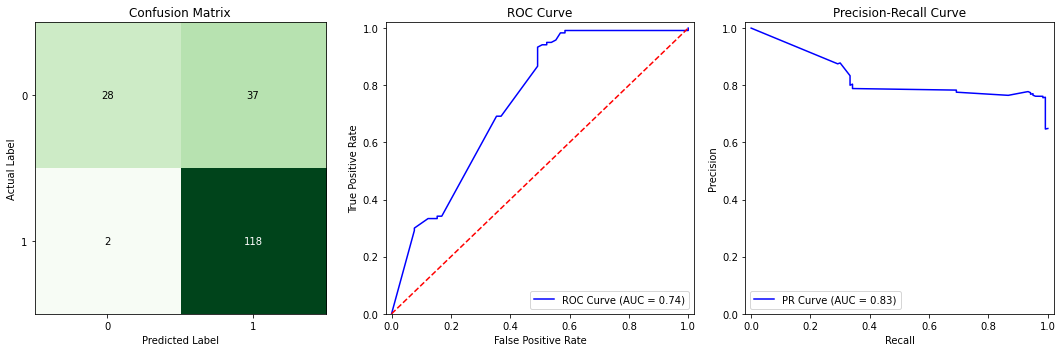

f1_scores for each fold [0.8698, 0.8742, 0.8925] ...... average 0.8788
precision_scores for each fold [0.7874, 0.7853, 0.8204] ...... average 0.7977
recall_scores for each fold [0.9716, 0.9858, 0.9786] ...... average 0.9787
accuracy_scores for each fold [0.8, 0.8049, 0.8382] ...... average 0.8144


In [26]:
gbc_tune = GradientBoostingClassifier(**best_gbc_para,random_state = 42)

gbc_tune.fit(x_train,y_train)

y_pred_gbc = gbc_tune.predict(x_test)

y_gbc_proba = gbc_tune.predict_proba(x_test)

classification_metrics(y_test, y_pred_gbc)
performance_eval(y_test,y_pred_gbc,y_gbc_proba[:, 1])
stratified_cv_(GradientBoostingClassifier(**best_gbc_para,random_state = 42), x, y, n_splits=3)

## Feature Importance 

Now that we know the best model is a Random Forest Classifier, we can determine which features the model thought were the most important in making a decision. Using impurity-based feature importances / Gini importance and SHAP values

In [27]:
def feature_importance(df, model):
    feat = pd.DataFrame(columns=[ 'feature', 'importance'])
    feat["feature"] = df.columns
    feat["importance"] = model.feature_importances_
    
    return feat.sort_values (by="importance", ascending=False)

Text(0, 0.5, 'Features')

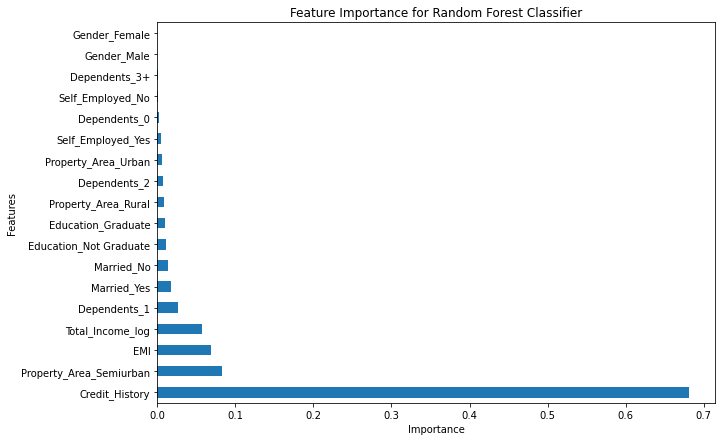

In [32]:
ax = feature_importance(x_test,rfc_tune).plot('feature','importance','barh' 
                             , title = f'Feature Importance for Random Forest Classifier'
                             , figsize=(10,7)
                             , legend = False)
ax.set_xlabel("Importance")
ax.set_ylabel("Features")

In [29]:
import shap 

In [37]:
explainer = shap.Explainer(rfc_tune, x_test)
shap_values = explainer(x_test)

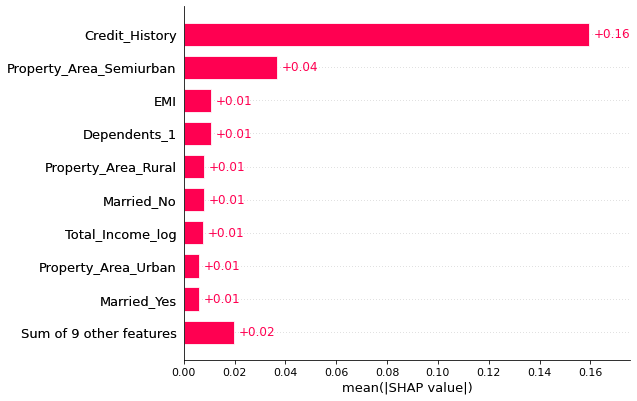

In [39]:
shap.plots.bar(shap_values[:, :, 1])


## Save Best Performing Model 

In [ ]:
filename = "rfc_tune.pickle"

pickle.dump(rfc_tune, open(filename, "wb"))